In [126]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [127]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [128]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [129]:
#Normalizing the data
X_train = X_train/255
X_test = X_test/255

In [130]:
#Reshaping the data
X_train_reshaped = X_train.reshape(-1,28*28)
X_test_reshaped = X_test.reshape(-1,28*28)

In [131]:
def relu(x):
  return np.maximum(0,x)

def relu_derivative(x):
  return (x > 0 ) * 1

def softmax(x):
  e_x = np.exp(x - np.max(x,axis=1,keepdims = True))
  return e_x / np.sum(e_x , axis=1, keepdims = True)

def cross_entropy(y_pred, y_true):
  m = y_true.shape[0]
  log_likelihood = -y_true*np.log(y_pred[range(m), y_true])
  loss = np.sum(log_likelihood) / m
  return loss

def accuracy(y_pred, y_true):
  predictions = np.argmax(y_pred, axis=1)
  return np.mean(predictions == y_true)

def xavier_init(size):
  in_dim , out_dim = size
  xavier_lim = np.sqrt(6. / (in_dim + out_dim))
  return np.random.uniform(-xavier_lim, xavier_lim, size)

In [132]:
class RMSprop:
  def __init__(self, dims, lr=0.001, rho = 0.9, epsilon= 1e-8):
    self.lr = lr
    self.rho = rho
    self.epsilon = epsilon
    self.cache = {i: np.zeros(dims[i]) for i in range(len(dims))}

  def update(self, params, grads):
    for i, param in enumerate(params):
      self.cache[i] = self.rho * self.cache[i] + (1-self.rho) * (grads[i] ** 2)
      params[i] -= (self.lr*grads[i]) / (np.sqrt(self.cache[i]) + self.epsilon)

In [133]:
class MLP:
  def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
    self.W1 = xavier_init(( input_dim, hidden_dim1))
    self.b1 = np.zeros((1,hidden_dim1))
    self.W2 = xavier_init(( hidden_dim1, hidden_dim2))
    self.b2 = np.zeros((1,hidden_dim2))
    self.W3 = xavier_init(( hidden_dim2, output_dim))
    self.b3 = np.zeros((1,output_dim))
    self.params = [self.W1, self.b1 ,self.W2 ,self.b2, self.W3 ,self.b3]
    self.rmsprop = RMSprop([self.W1.shape, self.b1.shape ,self.W2.shape ,self.b2.shape, self.W3.shape ,self.b3.shape])

  def forward(self,X):
    self.Z1 = np.dot(X,self.W1) + self.b1
    self.A1 = relu(self.Z1)
    self.Z2 = np.dot(self.A1,self.W2) + self.b2
    self.A2 = relu(self.Z2)
    self.Z3 = np.dot(self.A2,self.W3) + self.b3
    self.A3 = softmax(self.Z3)
    return self.A3

  def backward(self,X,y):
    m = y.shape[0]
    y_one_hot = np.zeros((m,self.W3.shape[1]))
    y_one_hot[np.arange(m),y] = 1

    dZ3 = self.A3 - y_one_hot
    dW3 = np.dot(self.A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims = True) / m

    dA2 = np.dot(dZ3, self.W3.T)
    dZ2 = dA2 * relu_derivative(self.Z2)
    dW2 = np.dot(self.A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims= True) / m

    dA1 = np.dot(dZ2, self.W2.T)
    dZ1 = dA1 * relu_derivative(self.Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims= True) / m

    grads = [dW1, db1, dW2, db2, dW3,db3]
    self.rmsprop.update(self.params, grads)

  # Training Loop
  def train(self,X,y, epochs=50):
    losses = []  # List to store loss values
    for epoch in range(epochs):
      output = self.forward(X)
      loss = cross_entropy(output, y)
      losses.append(np.abs(loss))
      self.backward(X,y)

      if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {np.abs(loss)}')

    # After all epochs, plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

  def get_first_layer_activations(self,X):
    self.Z1 = np.dot(X,self.W1) + self.b1
    self.A1 = relu(self.Z1)
    # first layer -> 'fc1' and uses ReLU activation
    return self.A1


Epoch 0, Loss: 535.5814762093195
Epoch 5, Loss: 313.72104421571896
Epoch 10, Loss: 206.1594319118936
Epoch 15, Loss: 162.97098140648865
Epoch 20, Loss: 138.61277826173733
Epoch 25, Loss: 121.19717964479881
Epoch 30, Loss: 105.21025678193541
Epoch 35, Loss: 101.68842894597846
Epoch 40, Loss: 95.86123722962876
Epoch 45, Loss: 86.00498546202968


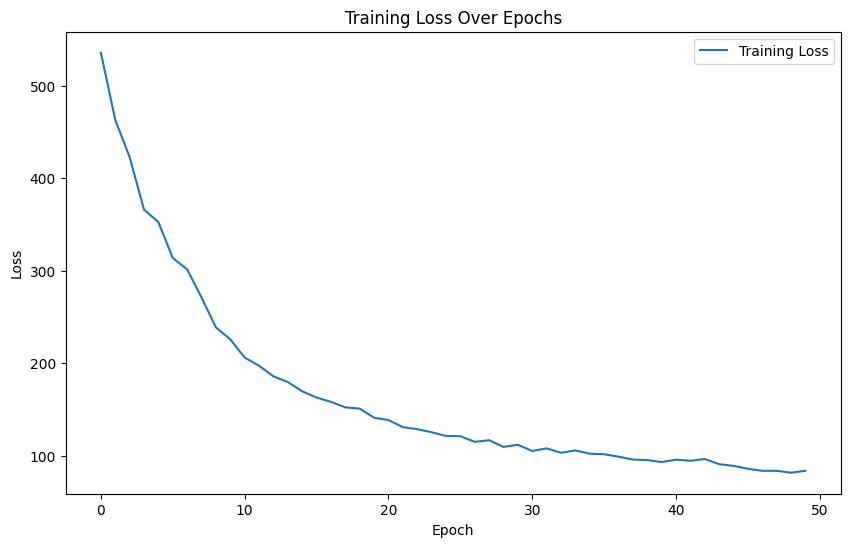

In [134]:
#Training the MLP
input_dim = 28*28
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = 10
epochs = 50

mlp = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim)
mlp.train(X_train_reshaped, y_train, epochs)

In [135]:
#Testing the MLP
y_test_pred = mlp.forward(X_test_reshaped)
test_loss = cross_entropy(y_test_pred, y_test)
test_acc = accuracy(y_test_pred, y_test)
print(f"\nTest Loss: {np.abs(test_loss):.4f}, Test Accuracy: {test_acc * 100:.2f}%")


Test Loss: 80.9318, Test Accuracy: 90.26%


In [136]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [137]:
np.argmax(y_test_pred, axis=1)

array([7, 2, 1, ..., 4, 5, 6])

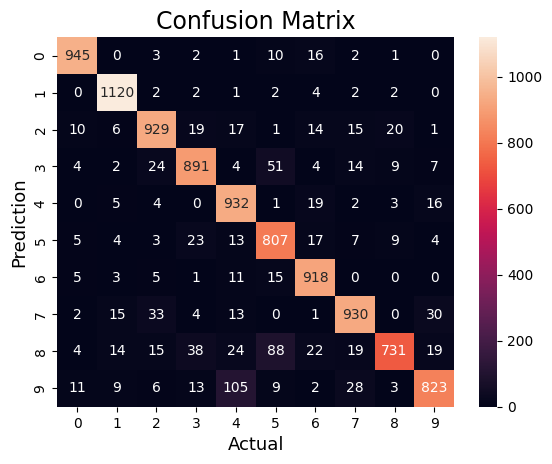

In [138]:
cm = confusion_matrix(y_test,np.argmax(y_test_pred, axis=1))
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

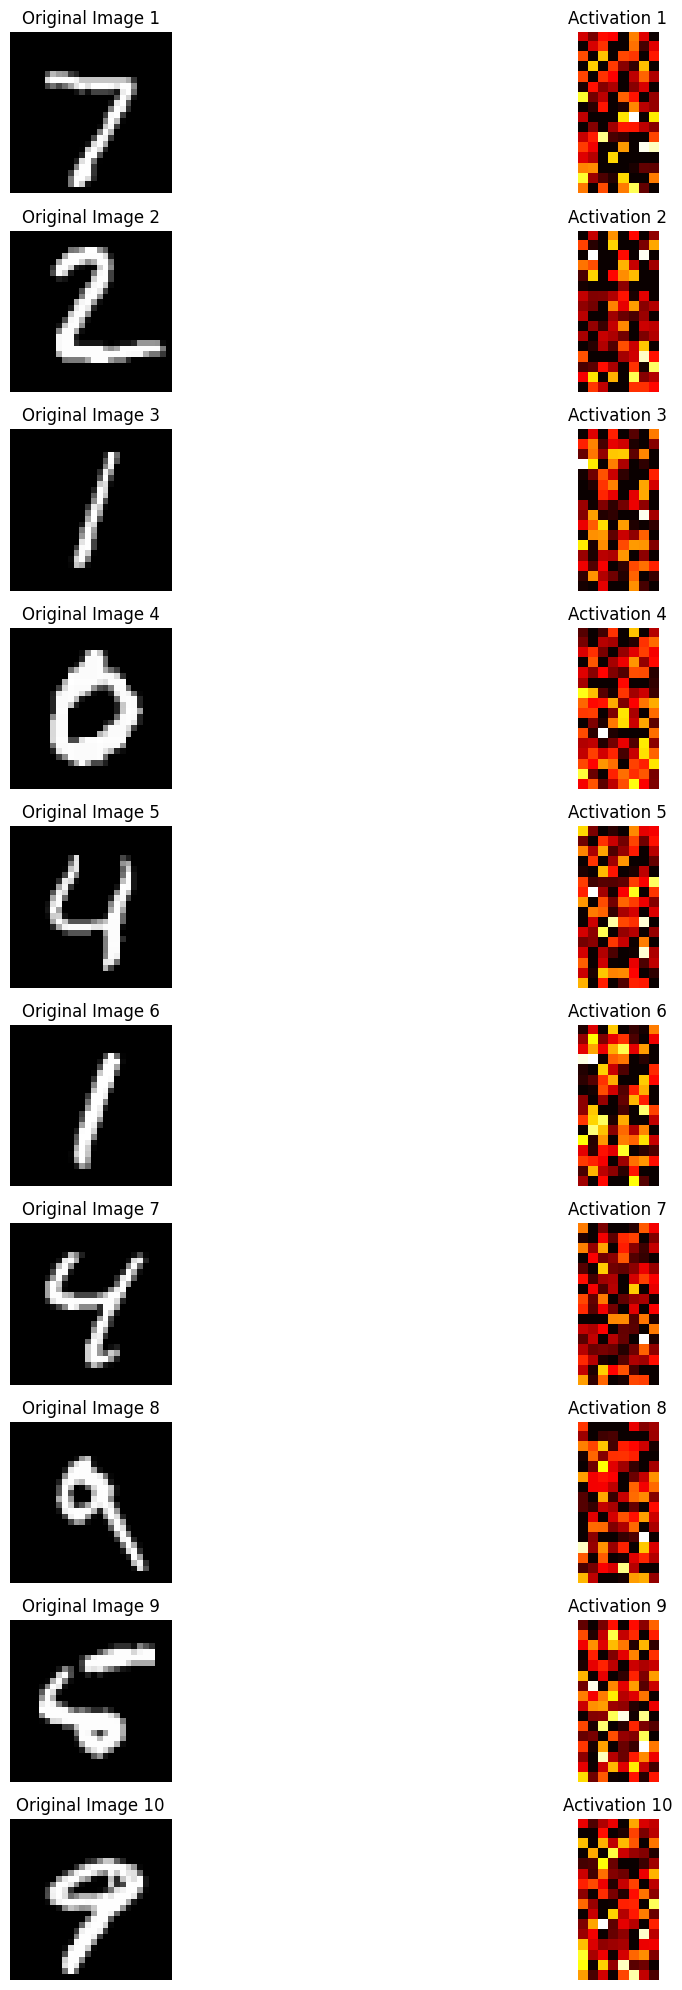

In [139]:
# Select 10 images from the test dataset
images = X_test[:10]

# Get first layer activations
activations = mlp.get_first_layer_activations(X_test_reshaped[:10])

# Plotting
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15, 20))
for i, (img, activation) in enumerate(zip(images, activations)):
    axs[i, 0].imshow(img.squeeze(), cmap='gray')
    axs[i, 0].set_title(f'Original Image {i+1}')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(activation.reshape(-1, 8), cmap='hot', interpolation='nearest')
    axs[i, 1].set_title(f'Activation {i+1}')
    axs[i, 1].axis('off')
plt.tight_layout()
plt.show()


Progress: 100%|██████████| 20/20 [00:01<00:00, 12.29it/s]


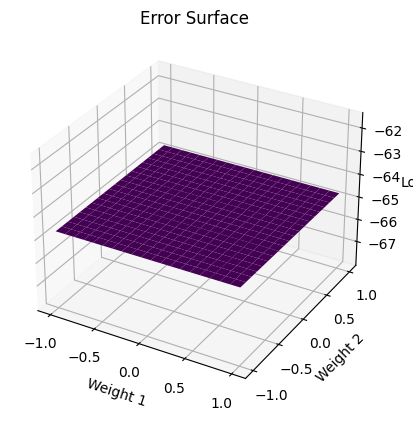

In [147]:

from tqdm import tqdm
def compute_loss(mlp,w1,w2,data,labels):
  #saving original weights
  original_w1 = np.copy(mlp.W1[0,0])
  original_w2 = np.copy(mlp.W1[1,0])

  #setting new weights
  mlp.W1[0,0] = w1
  mlp.W1[1,0] = w2

  outputs = mlp.forward(data)
  loss = cross_entropy(outputs,labels)

  #restoring old weights
  mlp.W1[0,0] = original_w1
  mlp.W1[1,0] = original_w2

  return loss

# Iterating Over Weight Values
w1_range = np.linspace(-1, 1, 20)
w2_range = np.linspace(-1, 1, 20)
w1_grid,w2_grid = np.meshgrid(w1_range,w2_range)

losses = np.zeros((len(w1_range), len(w2_range)))

for i in tqdm(range(len(w1_range)), desc="Progress", leave=True):
  for j in range(len(w2_range)):
    w1 = w1_grid[i,j]
    w2 = w2_grid[i,j]
    loss = compute_loss(mlp,w1,w2,X_train_reshaped[:100],y_train[:100])
    losses[i,j] = loss


# Plotting the Error Surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(w1_grid, w2_grid, losses, cmap='viridis', edgecolor="none")
ax.set_xlabel('Weight 1')
ax.set_ylabel('Weight 2')
ax.set_zlabel('Loss')
plt.title('Error Surface')
plt.show()


## TASK-B

### AutoEncoder model

In [ ]:
# Definition of the Autoencoder model as a subclass of the TensorFlow Model class

class SimpleAutoencoder:
  def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
    self.W1 = xavier_init(( input_dim, hidden_dim1))
    self.b1 = np.zeros((1,hidden_dim1))
    self.W2 = xavier_init(( hidden_dim1, hidden_dim2))
    self.b2 = np.zeros((1,hidden_dim2))
    self.W3 = xavier_init(( hidden_dim2, output_dim))
    self.b3 = np.zeros((1,output_dim))
    self.W4 = xavier_init(( input_dim, hidden_dim1))
    self.b4 = np.zeros((1,hidden_dim1))
    self.W5 = xavier_init(( hidden_dim1, hidden_dim2))
    self.b5 = np.zeros((1,hidden_dim2))
    self.W6 = xavier_init(( hidden_dim2, output_dim))
    self.b6 = np.zeros((1,output_dim))
    self.params = [self.W1, self.b1 ,self.W2 ,self.b2, self.W3 ,self.b3,self.W4, self.b4 ,self.W5 ,self.b5, self.W6 ,self.b6]
    self.rmsprop = RMSprop([self.W1.shape, self.b1.shape ,self.W2.shape ,self.b2.shape, self.W3.shape ,self.b3.shape, self.W4.shape, self.b4.shape ,self.W5.shape ,self.b5.shape, self.W6.shape ,self.b6.shape])

  def forward(self,X):
    #encoder
    self.Z1 = np.dot(X,self.W1) + self.b1
    self.A1 = relu(self.Z1)
    self.Z2 = np.dot(self.A1,self.W2) + self.b2
    self.A2 = relu(self.Z2)
    self.Z3 = np.dot(self.A2,self.W3) + self.b3
    self.A3 = softmax(self.Z3)
    #decoder
    self.Z4 = np.dot(self.A3,self.W4) + self.b4
    self.A4 = relu(self.Z4)
    self.Z5 = np.dot(self.A4,self.W5) + self.b5
    self.A5 = relu(self.Z5)
    self.Z6 = np.dot(self.A5,self.W6) + self.b6

    return self.Z6

  def backward(self,X,y):
    m = y.shape[0]
    y_one_hot = np.zeros((m,self.W3.shape[1]))
    y_one_hot[np.arange(m),y] = 1

    dZ3 = self.A3 - y_one_hot
    dW3 = np.dot(self.A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims = True) / m

    dA2 = np.dot(dZ3, self.W3.T)
    dZ2 = dA2 * relu_derivative(self.Z2)
    dW2 = np.dot(self.A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims= True) / m

    dA1 = np.dot(dZ2, self.W2.T)
    dZ1 = dA1 * relu_derivative(self.Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims= True) / m

    grads = [dW1, db1, dW2, db2, dW3,db3]
    self.rmsprop.update(self.params, grads)

  # Training Loop
  def train(self,X,y, epochs=50):
    losses = []  # List to store loss values
    for epoch in range(epochs):
      output = self.forward(X)
      loss = cross_entropy(output, y)
      losses.append(np.abs(loss))
      self.backward(X,y)

      if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {np.abs(loss)}')

    # After all epochs, plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

  def get_first_layer_activations(self,X):
    self.Z1 = np.dot(X,self.W1) + self.b1
    self.A1 = relu(self.Z1)
    # first layer -> 'fc1' and uses ReLU activation
    return self.A1



### SVM model